# Exercises for Week 10

In [1]:
%matplotlib inline
%matplotlib widget 

import cv2
import maxflow
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import ipywidgets as widgets
from matplotlib.patches import Circle
from IPython.display import display

## Hair removal

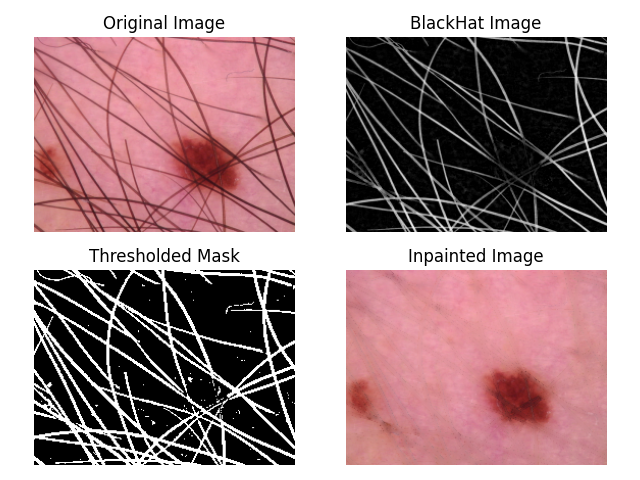

In [ ]:
def removeHair(img_org, img_gray, kernel_size=25, threshold=10, radius=3):
    # kernel for the morphological filtering
    
    #kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel_size, kernel_size))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    # perform the hat transform on the grayscale image
    hat_img = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, kernel) # for sample_001
    #hat_img = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, kernel) # for sample_002
    
    # threshold the hair contours
    _, thresh = cv2.threshold(hat_img, threshold, 255, cv2.THRESH_BINARY)
    
    # inpaint the original image depending on the mask
    img_out = cv2.inpaint(img_org, thresh, radius, cv2.INPAINT_TELEA)
    
    return hat_img, thresh, img_out

# read the image file (test both sample_001 and sample_002)
file_path = './sample_001.jpg'
#file_path = './sample_002.png'

img_bgr = cv2.imread(file_path)

# resize the image
max_size = 256
h, w = img_bgr.shape[:2]
scale = min(max_size / w, max_size / h)
if scale < 1:
    new_size = (int(w * scale), int(h * scale))
    img_bgr = cv2.resize(img_bgr, new_size, interpolation=cv2.INTER_AREA)

# permute color channels and convert to grayscale
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# apply hair removal; note: kernel_size and threshold can be adjusted as needed
blackhat, thresh, img_out = removeHair(img_rgb, img_gray, kernel_size=7, threshold=10)

# plot the images
plt.figure()

# original image
plt.subplot(2, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

# hat-transformed image
plt.subplot(2, 2, 2)
plt.imshow(blackhat, cmap="gray")
plt.title("BlackHat Image")
plt.axis("off")

# thresholded mask
plt.subplot(2, 2, 3)
plt.imshow(thresh, cmap="gray")
plt.title("Thresholded Mask")
plt.axis("off")

# inpainted image
plt.subplot(2, 2, 4)
plt.imshow(img_out)
plt.title("Inpainted Image")
plt.axis("off")

plt.tight_layout()
plt.show()

## Region growing

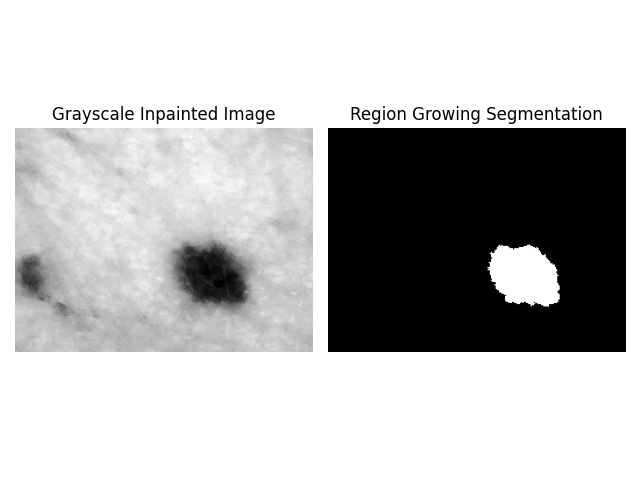

In [3]:
def regionGrowing(image, seed, threshold):
    h, w = image.shape
    mask = np.zeros((h, w), dtype=bool)
    region_pixels = []
    stack = [seed]
    
    # initialize the region's intensity mean with the seed value
    region_mean = float(image[seed])
    count = 1
    
    mask[seed] = True
    region_pixels.append(seed)
    
    # 4-connected neighbors: up, down, left, right
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    while stack:
        x, y = stack.pop()
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if 0 <= nx < h and 0 <= ny < w and mask[nx, ny] == 0:
                pixel_val = int(image[nx, ny])
                
                # compare the pixel intensity to the current region mean
                if abs(pixel_val - region_mean) <= threshold:
                    mask[nx, ny] = 1
                    stack.append((nx, ny))
                    region_pixels.append((nx, ny))
                    
                    # update region mean dynamically
                    region_mean = (region_mean * count + pixel_val) / (count + 1)
                    count += 1
                    
    return mask

# we need a grayscale version of img_out.
gray_img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2GRAY)

# find the darkest pixel
min_index = np.unravel_index(np.argmin(gray_img_out), gray_img_out.shape)

# apply region growing segmentation using the darkest pixel as the seed
segmentation_mask = regionGrowing(gray_img_out, min_index, threshold=40)

# plot the original grayscale image and the segmentation mask
plt.figure()

# grayscale image
plt.subplot(1, 2, 1)
plt.imshow(gray_img_out, cmap='gray')
plt.title("Grayscale Inpainted Image")
plt.axis("off")

# segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap='gray')
plt.title("Region Growing Segmentation")
plt.axis("off")

plt.tight_layout()
plt.show()

## Watershed algorithm

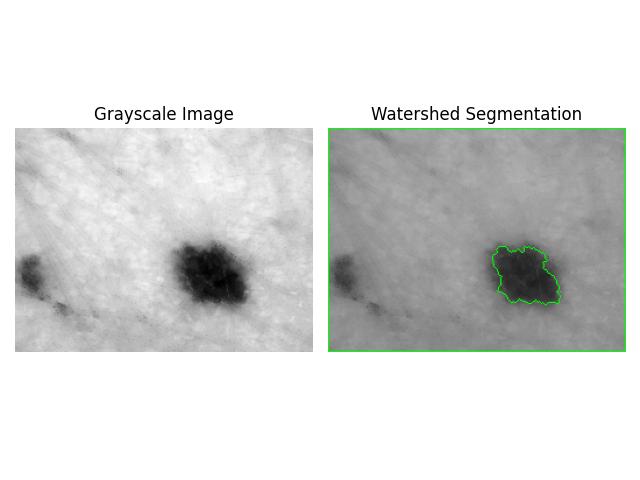

In [4]:
def watershedAlgorithm(gray_img, kernel_size=3, opening_iter=2, dilation_iter=3, dt_thresh=0.5):
    # apply Otsu's thresholding (with inversion) to obtain a binary image
    ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # remove noise with morphological opening
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=opening_iter)
    
    # dilate to obtain sure background regions
    sure_bg = cv2.dilate(opening, kernel, iterations=dilation_iter)
    
    # use distance transform to get sure foreground regions
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, dt_thresh * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # the unknown region is the difference between sure background and sure foreground
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # marker labeling
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0   
    
    # apply watershed algorithm
    img_color = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers)
    
    # mark the watershed boundaries in green (where marker == -1)
    img_color[markers == -1] = [0, 255, 0]
    
    return markers, img_color

# apply watershed algorithm:
markers, segmented_img = watershedAlgorithm(gray_img_out)

# plot the original grayscale image and the watershed segmentation result
plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(gray_img_out, cmap='gray')
plt.title("Grayscale Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
plt.title("Watershed Segmentation")
plt.axis("off")

plt.tight_layout()
plt.show()

## Graph-cut
### If it doesn't work, downgrade jupyter by: pip install "notebook<7"
### Also run: pip install ipympl opencv-python ipywidgets PyMaxflow

In [5]:
def graphcut(image, scribble_mask, lambda_val=50, sigma=10):
    H, W, _ = image.shape
    img = image.astype(np.float64)
    
    # identify scribbled regions
    fg_pixels = scribble_mask == 1  # definite foreground
    bg_pixels = scribble_mask == 2  # definite background
    
    # compute mean colors for scribbled foreground and background
    fg_mean = np.mean(img[fg_pixels], axis=0) if np.any(fg_pixels) else np.zeros(3)
    bg_mean = np.mean(img[bg_pixels], axis=0) if np.any(bg_pixels) else np.zeros(3)
    
    # data costs based on squared color distances
    data_cost_fg = np.sum((img - fg_mean)**2, axis=2)
    data_cost_bg = np.sum((img - bg_mean)**2, axis=2)
    
    # normalize the data costs
    data_cost_fg = data_cost_fg / (np.max(data_cost_fg) + 1e-8)
    data_cost_bg = data_cost_bg / (np.max(data_cost_bg) + 1e-8)
    
    # build the graph
    g = maxflow.Graph[float]()
    nodeids = g.add_grid_nodes((H, W))
    
    # terminal (data) capacities
    source_cap = data_cost_fg.copy()
    sink_cap = data_cost_bg.copy()
    
    # for scribbled pixels, force the label
    source_cap[scribble_mask == 1] = 0      # Force foreground.
    sink_cap[scribble_mask == 1] = 1e9
    source_cap[scribble_mask == 2] = 1e9      # Force background.
    sink_cap[scribble_mask == 2] = 0
    
    g.add_grid_tedges(nodeids, source_cap, sink_cap)
    
    # add smoothness (neighborhood) terms
    for i in range(H):
        for j in range(W):
            if j < W - 1:
                diff = np.linalg.norm(img[i, j] - img[i, j+1])
                weight = lambda_val * np.exp(- (diff**2) / (2 * sigma**2))
                g.add_edge(nodeids[i, j], nodeids[i, j+1], weight, weight)
                
            if i < H - 1:
                diff = np.linalg.norm(img[i, j] - img[i+1, j])
                weight = lambda_val * np.exp(- (diff**2) / (2 * sigma**2))
                g.add_edge(nodeids[i, j], nodeids[i+1, j], weight, weight)
                
    # compute the min-cut
    g.maxflow()
    seg_mask = np.zeros((H, W), dtype=bool)
    for i in range(H):
        for j in range(W):
            seg_mask[i, j] = True if g.get_segment(nodeids[i, j]) == 0 else False
            
    return seg_mask

ToggleButtons(description='Mode:', options=(('Foreground', 'foreground'), ('Background', 'background')), value…

Button(description='Run Graph-Cut', style=ButtonStyle())

Output()

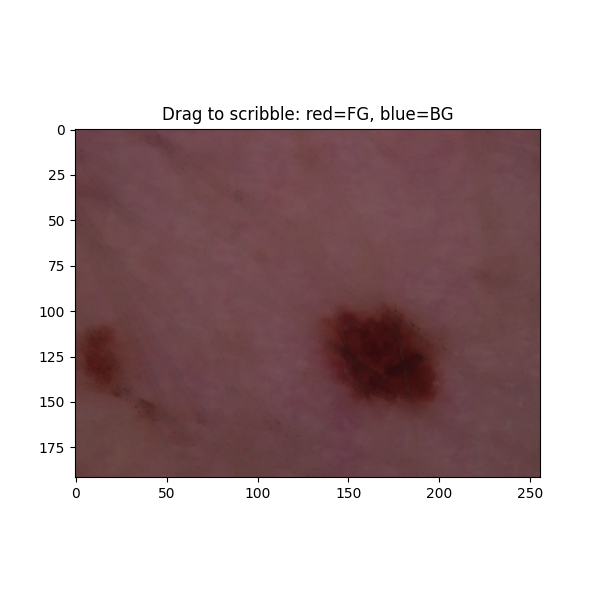

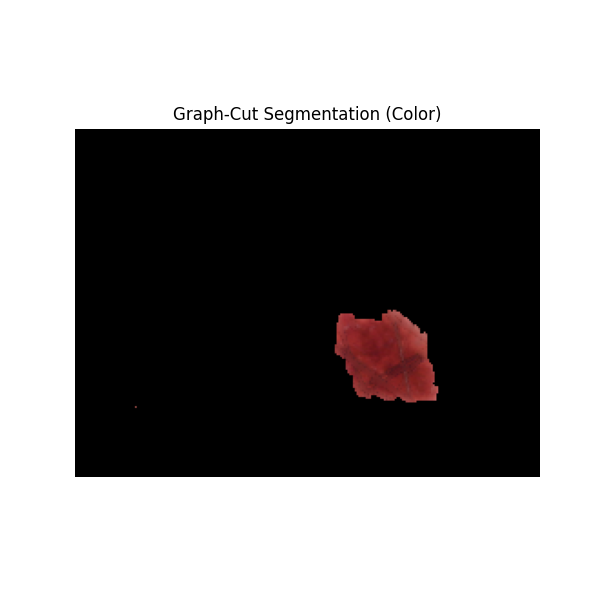

In [9]:
# replace 'path_to_image.jpg' with the path to your image.
image_path = './example.jpg'

image_bgr = cv2.imread(image_path)
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Look at the previously cleaned up image instead
image = img_out

# below are some codes and functions irrelevant to graph-cut
def on_press(event):
    global dragging
    if event.inaxes != ax:
        return
    dragging = True
    draw_at(event.xdata, event.ydata)

def on_motion(event):
    if dragging and event.inaxes == ax:
        draw_at(event.xdata, event.ydata)
        
def on_release(event):
    global dragging
    dragging = False
    
def on_mode_change(change):
    global current_mode
    current_mode = change['new']

def on_segment_clicked(b):
    with output:
        output.clear_output()
        print("Running Graph-Cut segmentation...")
    seg_mask = graphcut(image, scribble_mask)
    
    result_color = np.zeros_like(image)
    result_color[~seg_mask] = image[~seg_mask]

    fig2, ax2 = plt.subplots(figsize=(6, 6))
    ax2.imshow(result_color)
    ax2.set_title("Graph-Cut Segmentation (Color)")
    ax2.axis('off')
    plt.show()
    
def draw_at(xdata, ydata):
    global scribble_mask, overlay_data, scribble_points
    x, y = int(xdata), int(ydata)
    if current_mode == 'foreground':
        color = (255, 0, 0)
        mask_value = 1
    else:
        color = (0, 0, 255)
        mask_value = 2

    cv2.circle(scribble_mask, (x, y), brush_radius, mask_value, -1)
    cv2.circle(overlay_data, (x, y), brush_radius, color, -1)
    scribble_points.append((x, y, brush_radius, color))
    overlay_image.set_data(overlay_data)
    fig.canvas.draw_idle()
    
scribble_mask = np.zeros(image.shape[:2], dtype=np.uint8)
brush_radius = 5
current_mode = 'foreground'
overlay_data = np.zeros_like(image, dtype=np.uint8)
scribble_points = []
dragging = False

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(image)
overlay_image = ax.imshow(overlay_data, alpha=0.5)
ax.set_title("Drag to scribble: red=FG, blue=BG")

fig.canvas.mpl_connect('button_press_event', on_press)
fig.canvas.mpl_connect('motion_notify_event', on_motion)
fig.canvas.mpl_connect('button_release_event', on_release)

mode_selector = widgets.ToggleButtons(
    options=[('Foreground', 'foreground'), ('Background', 'background')],
    description='Mode:'
)

mode_selector.observe(on_mode_change, names='value')
display(mode_selector)

segmentation_button = widgets.Button(description="Run Graph-Cut")
output = widgets.Output()

segmentation_button.on_click(on_segment_clicked)
display(segmentation_button, output)
plt.show()